<h1>はじめに</h1>

番外編１では、loto6の販売実績額のデータをBeautifulSoupを用いたウェブスクレイピングにより取得する手順を整理していきます。<br>
手順は以下になります。
1. requestsライブラリを開いてWebサイトから用いてhtmlを取得
2. BeautifulSoupライブラリを用いてhtmlから必要な部分を抽出
3. Pandasライブラリを用いてデータフレーム化・CSV保存<br>

<h1>requestsライブラリを開いてWebサイトから用いてhtmlを取得</h1>

まずは必要なライブラリをインポートします。

In [1]:
import requests

次にurlを決めます。今回は、販売実績等のLoto6のデータを提供されているサイト様のURLを指定します。<br>
http://sougaku.com/loto6/data/detail/

In [2]:
url = "http://sougaku.com/loto6/data/detail/"

次にセッションを取得しhtmlを取得します。セッションはとは何か？については以下のサイト様等が参考になると思います。<br>
http://qiita.com/hththt/items/07136ad74127999df271

In [3]:
session = requests.session()
res = session.get(url)
res.encoding = 'utf-8'
#データ確認
print(res.text[:1000])

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" lang="ja" xml:lang="ja">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="Content-Script-Type" content="text/javascript" />
<meta http-equiv="Content-Style-Type" content="text/css" />
<meta name="content-language" content="ja" />
<meta name="robots" content="all" />
<meta name="author" content="ロト６生活" />
<meta name="copyright" content="Copyright (c) VIAS. All Rights Reserved.">
<meta name="Keywords" content="ロト６,LOTO6,宝くじ,当選番号,ギャンブル,予想ソフト,分析,予想,リンク">
<meta name="Description" content="ロト６データ分析サービスは、ロト６生活が提供する分析に必要なデータを載せています。">
<title>ロト６第1196回抽選結果詳細データ</title>
<link rel="shortcut icon" href="/loto6/img/favicon.ico" />
<link rel="stylesheet" href="/loto6/css/style.css" type="text/css" media="all" />
<link rel="alternate" type


requestsを使って、htmlレスポンスを取得することができました。

<h1>BeautifulSoupライブラリを用いてhtmlから必要な部分を抽出</h1>

まずは必要なライブラリをインポートします。

In [4]:
from bs4 import BeautifulSoup

BeautifulSoupに先ほどのhtmlを与えます。

In [5]:
soup = BeautifulSoup(res.text, "html.parser")
#データ確認
print(soup.text[:100])














ロト６第1196回抽選結果詳細データ







  (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=


htmlとして理解しています。

次に実際にhtmlファイルを確認して該当箇所を抽出します。<br>
今回のケースでは「sokuho_tb1」というクラスに入っているので取得します。

In [6]:
soup = soup.find(class_='sokuho_tb1')
#データ確認
print(soup)

<table border="0" cellpadding="0" cellspacing="0" class="sokuho_tb1">
<tbody>
<tr>
<th class="tw1">
				抽選回
			</th>
<th class="tw2">
				抽選日
			</th>
<th class="tw2">
				販売実績額
			</th>
<th class="tw3">
				セット球
			</th>
</tr>
<tr>
<td>
				第1196回
			</td>
<td>
				2017年7月31日(月)
			</td>
<td>
				1,399,975,000円
			</td>
<td>
				F
			</td>
</tr>
</tbody>
</table>


販売実績額がありましたね。さらに絞り込んで値を抽出しましょう。

In [7]:
#tdの２番めを取得
soup.find_all('td')[2]

<td>
				1,399,975,000円
			</td>

In [8]:
#さらに必要な部分だけを取り出してintに変換
int(soup.find_all('td')[2].text.replace('\n', '').replace('\t', '')[:-3].replace(',', ''))

13999750

販売実績額が取得できました。

<h1>Pandasライブラリを用いてデータフレーム化・CSV保存</h1>

まずは必要なライブラリをインポートします。

In [9]:
import pandas as pd

データを格納するためのデータフレームを作成します。

In [10]:
#何回目まで取得するかを指定
last = 1196
#中身が空のデータフレームを定義
result = pd.DataFrame(index=range(1, last+1), columns=['販売実績額'])
#データ確認
result.head()

,販売実績額
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN


for文を使って値を埋めていきます。

In [11]:
#１回毎に販売額を取得して格納
for i in result.index:

    #対象回
    target = i

    #URLを指定
    if target == last:
        url = "http://sougaku.com/loto6/data/detail/"
    else:
        url = "http://sougaku.com/loto6/data/detail/index" + str(target) + ".html"

    session = requests.session()
    res = session.get(url)

    soup = BeautifulSoup(res.text, "html.parser")
    soup = soup.find(class_='sokuho_tb1')
    value = int(soup.find_all('td')[2].text.replace('\n', '').replace('\t', '')[:-3].replace(',', ''))
    #print(i, value)

    #結果を格納
    result.loc[i, '販売実績額'] = value

#結果確認    
result.head()

,販売実績額
1,1183183200
2,1218391000
3,1627702400
4,1483327400
5,1714530600


プロットもしておきましょう。

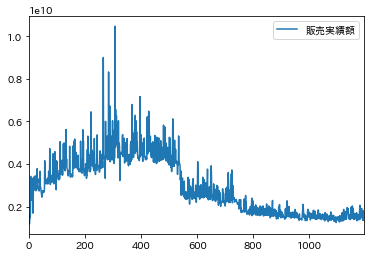

In [12]:
%matplotlib inline
result.plot()

うまく取れてそうですね。最後に保存をして完成です。

In [13]:
result.to_csv("salesData.csv")